# Import Libraries

In [1]:
!pip install keras-core --upgrade
!pip install -q keras-nlp
!pip install seaborn
!pip install textstat
!pip install nltk
!pip install tensorflow
!pip install tensorflow_hub


  Using cached tensorflow-2.15.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (475.2 MB)
  Using cached tensorboard-2.15.2-py3-none-any.whl (5.5 MB)
  Using cached keras-2.15.0-py3-none-any.whl (1.7 MB)
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    Uninstalling keras-3.3.3:
      Successfully uninstalled keras-3.3.3
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.16.2
    Uninstalling tensorboard-2.16.2:
      Successfully uninstalled tensorboard-2.16.2
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.16.1
    Uninstalling tensorflow-2.16.1:
      Successfully uninstalled tensorflow-2.16.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.16.1 requires tensorflow<2.17,>=2.16.1; platform_machine != "arm64" or platform_system != "Darwi

In [2]:
#pip install --upgrade tensorflow


In [3]:
import pandas as pd
import numpy as np
import re
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from textstat import flesch_reading_ease
import textstat

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import precision_score, recall_score

import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
import tensorflow as tf
#import tensorflow_hub as hub
import keras_core as keras
import keras_nlp
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
nltk.download('wordnet')
nltk.download('punkt')


Using TensorFlow backend


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)
print("KerasNLP version:", keras_nlp.__version__)

TensorFlow version: 2.15.1
Keras version: 0.1.7
KerasNLP version: 0.11.1


In [5]:
#df=pd.read_csv(r'train_essays.csv')

In [6]:
#df['generated'].value_counts()

# Loading the dataset

In [7]:
df=pd.read_csv(r'train_v2_drcat_02.csv')

In [8]:
df

,text,label,prompt_name,source,RDizzl3_seven
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False
...,...,...,...,...,...
44863,"Dear Senator,\n\nI am writing to you today to ...",1,Does the electoral college work?,kingki19_palm,True
44864,"Dear Senator,\n\nI am writing to you today to ...",1,Does the electoral college work?,kingki19_palm,True
44865,"Dear Senator,\n\nI am writing to you today to ...",1,Does the electoral college work?,kingki19_palm,True
44866,"Dear Senator,\n\nI am writing to you today to ...",1,Does the electoral college work?,kingki19_palm,True


In [9]:
df['label'].value_counts()

label
0    27371
1    17497
Name: count, dtype: int64

In [10]:
# Creating a new column indicating human or AI
df['source'] = np.where(df['label'] == 0, 'human', 'AI')




In [11]:
df['source'].value_counts()

source
human    27371
AI       17497
Name: count, dtype: int64

**Sampled 10000 essays from each AI and Human Text**

In [12]:
# Select a random sample of 10000 human-generated texts
human_texts = df[df['source'] == 'human'].sample(n=10000, random_state=42)

# Select all AI-generated texts
AI_texts = df[df['source'] == 'AI'].sample(n=10000, random_state=42)

# Concatenate the selected human-generated texts with all AI-generated texts
matched_df = pd.concat([human_texts, AI_texts])

# Shuffle the DataFrame to mix human and AI texts
matched_df = matched_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Now matched_df contains an equal number of human and AI generated texts

In [13]:
matched_df['source'].value_counts()

source
AI       10000
human    10000
Name: count, dtype: int64

In [14]:
matched_df

,text,label,prompt_name,source,RDizzl3_seven
0,It is well-documented that eating a wide varie...,1,Distance learning,AI,False
1,"Dear Principle,\n\nSome of my friends do commu...",0,Community service,human,False
2,"In the article ""Driveless Cars Are Coming"", Th...",0,Driverless cars,human,True
3,"They come in red, blue, green, black, and whit...",0,Car-free cities,human,True
4,"The quote ""Unless you try something beyond wha...",1,Mandatory extracurricular activities,AI,False
...,...,...,...,...,...
19995,Some individuals believe that they should see...,1,Seeking multiple opinions,AI,False
19996,"Dear Mrs. Smith,\n\nI think that policy 1 is t...",1,Cell phones at school,AI,False
19997,Driverless cars are coming and are closer than...,0,Driverless cars,human,True
19998,The idea of having driverless cars is quite th...,0,Driverless cars,human,True


# Text Preprocessing

In [15]:
from nltk.stem import WordNetLemmatizer
import re

# Initialize WordNet Lemmatizer
wc = WordNetLemmatizer()

# Initialize corpus to store preprocessed reviews
corpus = []

# Preprocess all the data
for i in range(len(matched_df)):
    review = matched_df['text'][i]
    review = re.sub('[^a-zA-Z]', " ", review)  # Remove non-alphabetic characters
    review = review.lower()  # Convert text to lowercase
    # Tokenization
    review = review.split()
    # Applying lemmatization
    d = [wc.lemmatize(word) for word in review]
    review = " ".join(d)
    # Append preprocessed review to corpus
    corpus.append(review)



In [16]:
corpus

['it is well documented that eating a wide variety of food contributes to a healthy lifestyle and support overall well being introducing healthier food option in a school cafeteria would encourage student to experiment and broaden their taste preference eating a more diverse range of food can lead to a healthier diet filled with essential vitamin and mineral nevertheless it is especially important to consider student who prefer the existing cafeteria food and how they would be affected by the introduction of healthier food option this could be done by offering more option and variety than previously offered catering to both healthier and existing preference even small change to existing food can still make a difference such a adding more fruit and vegetable to existing meal or replacing unhealthy snack with healthier one in conclusion it is vital that school should strive to provide student with healthy and varied food option in their cafeteria through the introduction of healthier cho

# Feature Engineering

To differentiate between human-written and AI-generated essays: we're performing feature engineering.

Feature engineering involves creating new features from the existing data to improve the performance of machine learning models. Here are some feature engineering ideas we're implementing on our dataset: Text Length, Lexical Diversity, Flesch Reading Ease.


Text Length (text_length):  

Text length refers to the number of words or characters in a piece of text.  
In our dataset, the text_length column contains the length of each essay in terms of the number of words.


Lexical Diversity (lexical_diversity):

Lexical diversity measures the variety of unique words used in a piece of text relative to the total number of words.  
It is calculated as the ratio of the number of unique words to the total number of words.  
A higher lexical diversity score indicates a greater variety of words used in the text.     
In our dataset, the lexical_diversity column contains the lexical diversity score for each essay.  


Flesch Reading Ease (flesch_reading_ease):  

Flesch Reading Ease is a readability metric that estimates how easy or difficult it is to read a piece of text.  
It is calculated based on the average sentence length and the average number of syllables per word.  
Higher Flesch Reading Ease scores indicate easier-to-read text, while lower scores indicate more difficult text.   Scores typically range from 0 to 100, with higher scores indicating better readability.   
In our dataset, the flesch_reading_ease column contains the Flesch Reading Ease score for each essay.  


Understanding these features can provide insights into the characteristics of the essays in our dataset, such as their length, complexity, and readability.   


# Code:

In [17]:
# from nltk.tokenize import word_tokenize
# from nltk.corpus import stopwords
# from textstat import flesch_reading_ease
# import textstat

# Feature Engineering: Text Length
matched_df['text_length'] = matched_df['text'].apply(lambda x: len(x))

# Feature Engineering: Lexical Diversity
def calculate_lexical_diversity(text):
    tokens = word_tokenize(text.lower())
    unique_tokens = set(tokens)
    return len(unique_tokens) / len(tokens) if len(tokens) > 0 else 0

matched_df['lexical_diversity'] = matched_df['text'].apply(calculate_lexical_diversity)

# Feature Engineering: Readability Metrics
matched_df['flesch_reading_ease'] = matched_df['text'].apply(lambda x: flesch_reading_ease(x))


In [18]:
matched_df['text_length']

0        1152
1        2302
2        1486
3        3084
4        2433
         ... 
19995    1943
19996    1449
19997    2188
19998    1986
19999    2418
Name: text_length, Length: 20000, dtype: int64

In [19]:

matched_df['lexical_diversity']

0        0.542105
1        0.300866
2        0.416667
3        0.481544
4        0.364026
           ...   
19995    0.383041
19996    0.382716
19997    0.466019
19998    0.487745
19999    0.376443
Name: lexical_diversity, Length: 20000, dtype: float64

In [20]:
matched_df['flesch_reading_ease']

0        40.58
1        73.47
2        70.97
3        65.01
4        58.11
         ...  
19995    50.26
19996    83.86
19997    61.46
19998    77.67
19999    46.51
Name: flesch_reading_ease, Length: 20000, dtype: float64

In [21]:
# Creating a new DataFrame with selected columns
new_df = matched_df[['text', 'label', 'source', 'text_length', 'lexical_diversity', 'flesch_reading_ease']]

In [22]:
new_df

,text,label,source,text_length,lexical_diversity,flesch_reading_ease
0,It is well-documented that eating a wide varie...,1,AI,1152,0.542105,40.58
1,"Dear Principle,\n\nSome of my friends do commu...",0,human,2302,0.300866,73.47
2,"In the article ""Driveless Cars Are Coming"", Th...",0,human,1486,0.416667,70.97
3,"They come in red, blue, green, black, and whit...",0,human,3084,0.481544,65.01
4,"The quote ""Unless you try something beyond wha...",1,AI,2433,0.364026,58.11
...,...,...,...,...,...,...
19995,Some individuals believe that they should see...,1,AI,1943,0.383041,50.26
19996,"Dear Mrs. Smith,\n\nI think that policy 1 is t...",1,AI,1449,0.382716,83.86
19997,Driverless cars are coming and are closer than...,0,human,2188,0.466019,61.46
19998,The idea of having driverless cars is quite th...,0,human,1986,0.487745,77.67


<ipython-input-23-5820b1183170>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")  # Rotate x-axis labels by 45 degrees


Text(0.5, 1.0, 'Distribution of prompt name')

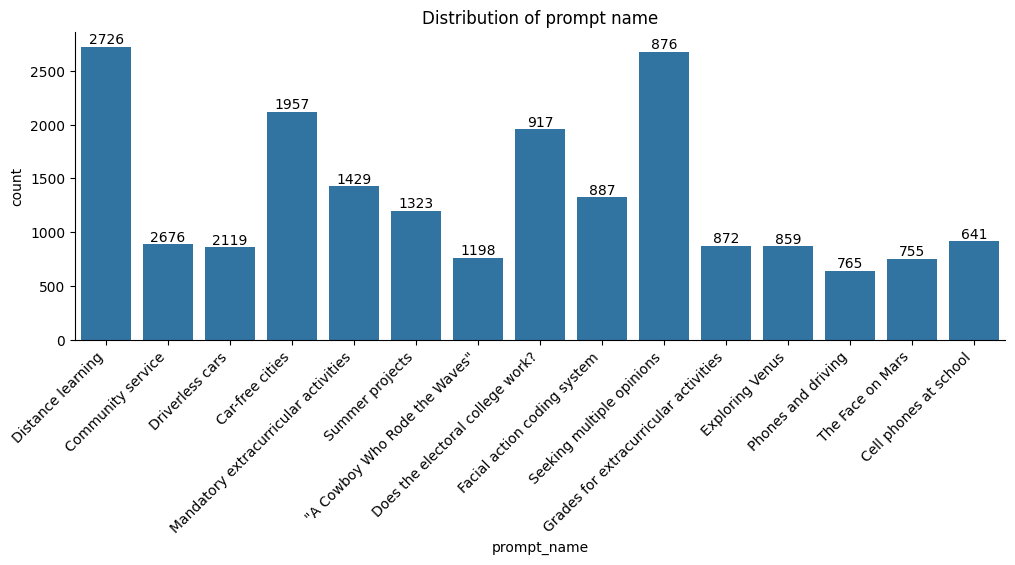

In [23]:
f, ax = plt.subplots(figsize=(12, 4))

sns.despine()
ax = sns.countplot(data=matched_df,
                   x="prompt_name")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")  # Rotate x-axis labels by 45 degrees

abs_values = matched_df['prompt_name'].value_counts().values

ax.bar_label(container=ax.containers[0], labels=abs_values)

ax.set_title("Distribution of prompt name")


Text(0.5, 1.0, 'Distribution of Generated Text')

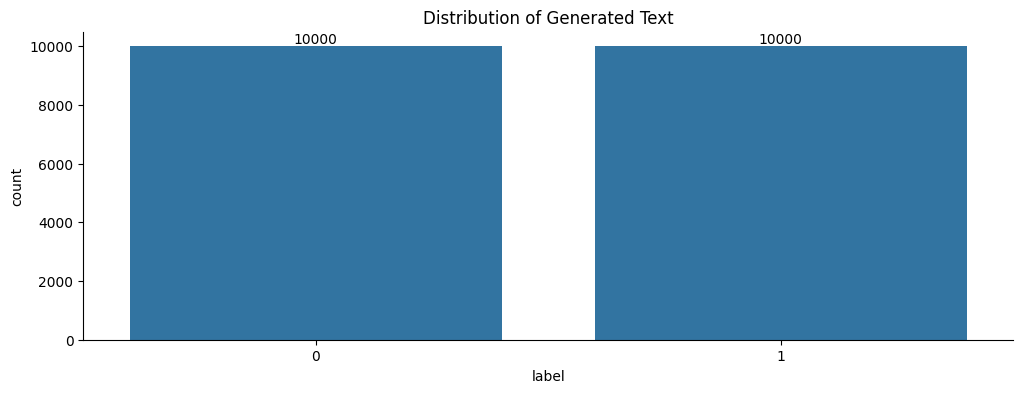

In [24]:
f, ax = plt.subplots(figsize=(12, 4))

sns.despine()
ax = sns.countplot(data=matched_df,
                   x="label")

abs_values = matched_df['label'].value_counts().values

ax.bar_label(container=ax.containers[0], labels=abs_values)

ax.set_title("Distribution of Generated Text")

#Understanding source & text_length

In [25]:
# Filtering AI-generated text with lengths less than 500, 1000 and greater than 1000
ai_less_than_1000 = new_df[(new_df['source'] == 'AI') & (new_df['text_length'] < 1000)].shape[0]
ai_less_than_500 = new_df[(new_df['source'] == 'AI') & (new_df['text_length'] < 500)].shape[0]
ai_greater_than_1000 = new_df[(new_df['source'] == 'AI') & (new_df['text_length'] > 1000)].shape[0]

# Filtering human text with lengths less than 500, 1000 and greater than 1000
human_less_than_1000 = new_df[(new_df['source'] == 'human') & (new_df['text_length'] < 1000)].shape[0]
human_less_than_500 = new_df[(new_df['source'] == 'human') & (new_df['text_length'] < 500)].shape[0]
human_greater_than_1000 = new_df[(new_df['source'] == 'human') & (new_df['text_length'] > 1000)].shape[0]

print("AI-generated text with length < 5000:", ai_less_than_500)
print("AI-generated text with length < 10000:", ai_less_than_1000)
print("AI-generated text with length > 10000:", ai_greater_than_1000)

print("Human text with length < 5000:", human_less_than_500)
print("Human text with length < 10000:", human_less_than_1000)
print("Human text with length > 10000:", human_greater_than_1000)

AI-generated text with length < 5000: 10
AI-generated text with length < 10000: 457
AI-generated text with length > 10000: 9543
Human text with length < 5000: 0
Human text with length < 10000: 572
Human text with length > 10000: 9423


# Understanding source & lexical_diversity

In [26]:

# Filter human and AI data separately
human_df = new_df[new_df['source'] == 'human']
ai_df = new_df[new_df['source'] == 'AI']

# Calculate min, max, and mode (most frequent) lexical diversity for human
human_min_lexical_diversity = human_df['lexical_diversity'].min()
human_max_lexical_diversity = human_df['lexical_diversity'].max()
human_mode_lexical_diversity = human_df['lexical_diversity'].mode()[0]  # Get the first mode if multiple modes exist

# Calculate min, max, and mode (most frequent) lexical diversity for AI
ai_min_lexical_diversity = ai_df['lexical_diversity'].min()
ai_max_lexical_diversity = ai_df['lexical_diversity'].max()
ai_mode_lexical_diversity = ai_df['lexical_diversity'].mode()[0]  # Get the first mode if multiple modes exist

# Print the results
print("Human Lexical Diversity:")
print("Minimum:", human_min_lexical_diversity)
print("Maximum:", human_max_lexical_diversity)
print("Mode:", human_mode_lexical_diversity)

print("\nAI Lexical Diversity:")
print("Minimum:", ai_min_lexical_diversity)
print("Maximum:", ai_max_lexical_diversity)
print("Mode:", ai_mode_lexical_diversity)


Human Lexical Diversity:
Minimum: 0.052298850574712646
Maximum: 0.7119565217391305
Mode: 0.5

AI Lexical Diversity:
Minimum: 0.11900532859680284
Maximum: 1.0
Mode: 0.5


# Understanding source & flesch_reading_ease

In [27]:
# Defining the readability ranges
readability_ranges = {
    'Very Difficult': (0, 30),
    'Difficult': (30, 50),
    'Moderate': (50, 70),
    'Easy': (70, 90),
    'Very Easy': (90, 100)
}

# Filter AI and human data separately
ai_df = new_df[new_df['source'] == 'AI']
human_df = new_df[new_df['source'] == 'human']

# Function to classify readability based on Flesch Reading Ease score
def classify_readability(score):
    for category, (lower, upper) in readability_ranges.items():
        if lower <= score < upper:
            return category

# Apply readability classification to AI essays
ai_df['Readability'] = ai_df['flesch_reading_ease'].apply(classify_readability)

# Apply readability classification to human essays
human_df['Readability'] = human_df['flesch_reading_ease'].apply(classify_readability)

# Print counts of essays in each readability category for AI and human sources
print("AI Essays Readability:")
print(ai_df['Readability'].value_counts())

print("\nHuman Essays Readability:")
print(human_df['Readability'].value_counts())


AI Essays Readability:
Readability
Moderate          4394
Difficult         3460
Easy              1598
Very Difficult     358
Very Easy          188
Name: count, dtype: int64

Human Essays Readability:
Readability
Easy              4920
Moderate          4433
Difficult          351
Very Easy          215
Very Difficult      47
Name: count, dtype: int64


<ipython-input-27-bfbb144e410a>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ai_df['Readability'] = ai_df['flesch_reading_ease'].apply(classify_readability)
<ipython-input-27-bfbb144e410a>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  human_df['Readability'] = human_df['flesch_reading_ease'].apply(classify_readability)


# Models

# Naive Bayes

In [28]:
matched_df['source']

0           AI
1        human
2        human
3        human
4           AI
         ...  
19995       AI
19996       AI
19997    human
19998    human
19999       AI
Name: source, Length: 20000, dtype: object

In [29]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer

# Assuming matched_df['source'] contains the labels

# Vectorize the text data using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf_vectorizer.fit_transform(matched_df['text'])

# Splitting the data into train and test sets (hold-out set)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, matched_df['source'], test_size=0.2, random_state=42)

# Naive Bayes model with Laplace smoothing
nb_model = MultinomialNB(alpha=1.0)  # Applying Laplace smoothing with alpha=1.0

# Perform k-fold cross-validation
cv_scores_nb = cross_val_score(nb_model, X_train, y_train, cv=5)
print("Cross-Validation Scores for Naive Bayes:", cv_scores_nb)
print("Mean Cross-Validation Accuracy for Naive Bayes:", cv_scores_nb.mean())
print("Standard Deviation of Cross-Validation Accuracy for Naive Bayes:", cv_scores_nb.std())

# Training the model
nb_model.fit(X_train, y_train)

# Predictions on train and test sets
y_pred_train_nb = nb_model.predict(X_train)
y_pred_test_nb = nb_model.predict(X_test)

# Accuracy on train and test sets
accuracy_train_nb = accuracy_score(y_train, y_pred_train_nb)
accuracy_test_nb = accuracy_score(y_test, y_pred_test_nb)
print("Train Set Accuracy for Naive Bayes:", accuracy_train_nb)
print("Test Set Accuracy for Naive Bayes:", accuracy_test_nb)

# Classification report on train and test sets
print("Classification Report on Train Set for Naive Bayes:")
print(classification_report(y_train, y_pred_train_nb))
print("Classification Report on Test Set for Naive Bayes:")
print(classification_report(y_test, y_pred_test_nb))

# Check for overfitting
if accuracy_train_nb > cv_scores_nb.mean():
    print("Warning: Naive Bayes model may be overfitting.")
else:
    print("No overfitting detected for Naive Bayes.")




Cross-Validation Scores for Naive Bayes: [0.9159375 0.918125  0.9221875 0.9290625 0.9225   ]
Mean Cross-Validation Accuracy for Naive Bayes: 0.9215625000000001
Standard Deviation of Cross-Validation Accuracy for Naive Bayes: 0.004493919503061907
Train Set Accuracy for Naive Bayes: 0.922625
Test Set Accuracy for Naive Bayes: 0.92125
Classification Report on Train Set for Naive Bayes:
              precision    recall  f1-score   support

          AI       0.96      0.89      0.92      8055
       human       0.89      0.96      0.92      7945

    accuracy                           0.92     16000
   macro avg       0.92      0.92      0.92     16000
weighted avg       0.92      0.92      0.92     16000

Classification Report on Test Set for Naive Bayes:
              precision    recall  f1-score   support

          AI       0.95      0.88      0.92      1945
       human       0.90      0.96      0.93      2055

    accuracy                           0.92      4000
   macro avg      

# Logistic Regression

In [30]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

# Splitting the data into train and test sets (hold-out set)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, matched_df['source'], test_size=0.2, random_state=42)



# Logistic Regression model with L2 regularization
logreg_model = LogisticRegression(max_iter=1000, penalty='l2', C=1.0)  # Applying L2 regularization with default C=1.0
logreg_model.fit(X_train, y_train)


# Perform k-fold cross-validation
cv_scores_lr = cross_val_score(logreg_model, X_tfidf, matched_df['source'], cv=5)
print("Cross-Validation Scores for Logistic Regression:", cv_scores_lr)
print("Mean Cross-Validation Accuracy for Logistic Regression:", cv_scores_lr.mean())
print("Standard Deviation of Cross-Validation Accuracy for Logistic Regression:", cv_scores_lr.std())

# Training the model
logreg_model.fit(X_train, y_train)

# Predictions on train and test sets
y_pred_train_lr = logreg_model.predict(X_train)
y_pred_test_lr = logreg_model.predict(X_test)

# Accuracy on train and test sets
accuracy_train_lr = accuracy_score(y_train, y_pred_train_lr)
accuracy_test_lr = accuracy_score(y_test, y_pred_test_lr)
print("Train Set Accuracy for Logistic Regression:", accuracy_train_lr)
print("Test Set Accuracy for Logistic Regression:", accuracy_test_lr)

# Classification report on train and test sets
print("Classification Report on Train Set for Logistic Regression:")
print(classification_report(y_train, y_pred_train_lr))
print("Classification Report on Test Set for Logistic Regression:")
print(classification_report(y_test, y_pred_test_lr))

# Check for overfitting
if accuracy_train_lr > cv_scores_lr.mean():
    print("Warning: Logistic Regression model may be overfitting.")
else:
    print("No overfitting detected for Logistic Regression.")



Cross-Validation Scores for Logistic Regression: [0.98325 0.9845  0.9825  0.987   0.9855 ]
Mean Cross-Validation Accuracy for Logistic Regression: 0.9845500000000001
Standard Deviation of Cross-Validation Accuracy for Logistic Regression: 0.001599999999999998
Train Set Accuracy for Logistic Regression: 0.987625
Test Set Accuracy for Logistic Regression: 0.98775
Classification Report on Train Set for Logistic Regression:
              precision    recall  f1-score   support

          AI       0.99      0.98      0.99      8055
       human       0.98      0.99      0.99      7945

    accuracy                           0.99     16000
   macro avg       0.99      0.99      0.99     16000
weighted avg       0.99      0.99      0.99     16000

Classification Report on Test Set for Logistic Regression:
              precision    recall  f1-score   support

          AI       0.99      0.98      0.99      1945
       human       0.98      0.99      0.99      2055

    accuracy              

# Random Forest

In [31]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier

# Splitting the data into train and test sets (hold-out set)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, matched_df['source'], test_size=0.2, random_state=42)

# Random Forest model with regularization (max_depth)
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)  # max_depth is a hyperparameter to control overfitting
rf_model.fit(X_train, y_train)

# Perform k-fold cross-validation
cv_scores_rf = cross_val_score(rf_model, X_tfidf, matched_df['source'], cv=5)
print("Cross-Validation Scores:", cv_scores_rf)
print("Mean Cross-Validation Accuracy:", cv_scores_rf.mean())
print("Standard Deviation of Cross-Validation Accuracy:", cv_scores_rf.std())

# Predictions on train and test sets
y_pred_train_rf = rf_model.predict(X_train)
y_pred_test_rf = rf_model.predict(X_test)

# Accuracy on train and test sets
accuracy_train_rf = accuracy_score(y_train, y_pred_train_rf)
accuracy_test_rf = accuracy_score(y_test, y_pred_test_rf)
print("Train Set Accuracy:", accuracy_train_rf)
print("Test Set Accuracy:", accuracy_test_rf)

# Classification report on train and test sets
print("Classification Report on Train Set:")
print(classification_report(y_train, y_pred_train_rf))
print("Classification Report on Test Set:")
print(classification_report(y_test, y_pred_test_rf))

# Check for overfitting
if accuracy_train_rf > cv_scores_rf.mean():
    print("Warning: Random Forest Model may be overfitting.")
else:
    print("No overfitting detected for Random Forest.")

Cross-Validation Scores: [0.968   0.96625 0.97075 0.97375 0.9705 ]
Mean Cross-Validation Accuracy: 0.9698500000000001
Standard Deviation of Cross-Validation Accuracy: 0.0025622255950637834
Train Set Accuracy: 0.984
Test Set Accuracy: 0.972
Classification Report on Train Set:
              precision    recall  f1-score   support

          AI       0.99      0.98      0.98      8055
       human       0.98      0.99      0.98      7945

    accuracy                           0.98     16000
   macro avg       0.98      0.98      0.98     16000
weighted avg       0.98      0.98      0.98     16000

Classification Report on Test Set:
              precision    recall  f1-score   support

          AI       0.98      0.96      0.97      1945
       human       0.96      0.98      0.97      2055

    accuracy                           0.97      4000
   macro avg       0.97      0.97      0.97      4000
weighted avg       0.97      0.97      0.97      4000

